<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_EPI_2D_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(EPI_2D_seq)=
# 2D EPI

In [8]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

# %% S1. SETUP sys

def seq_gre_epi(
    fov=240e-3, slice_thickness=8e-3, sz=(64, 64),
    Nread=64, Nphase=64,
    rf_flip_angle=90 * np.pi / 180, rf_duration=1e-3, rf_apodization=0.5, rf_time_bw_product=4,
    adc_duration_OG=0.25e-3, eddy_currents=True, eddy_currents_induced_delay=0.0000015,
    blip_duration=0.1e-3
):
    # choose the scanner limits
    system = pp.Opts(
        max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
        rf_ringdown_time=20e-6, rf_dead_time=100e-6,
        adc_dead_time=20e-6, grad_raster_time=10e-6
    )

    # %% S2. DEFINE the sequence
    seq = pp.Sequence()

    # Define rf events
    rf1, _, _ = pp.make_sinc_pulse(
        flip_angle=rf_flip_angle, duration=rf_duration,
        slice_thickness=slice_thickness, apodization=rf_apodization, time_bw_product=rf_time_bw_product,
        system=system, return_gz=True
    )

    # Define other gradients and ADC events
    a = int(system.adc_raster_time * Nread * 10**7)
    b = int(system.grad_raster_time * 10**7)
    c = int(adc_duration_OG * 10**7)
    lcm_ab = abs(a * b) // np.gcd(a, b)
    adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7


    eddy_currents_induced_delay*=eddy_currents

    gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
    gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
    adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
    gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

    # ======
    # CONSTRUCT SEQUENCE
    # ======
    # blip_duration=0.1e-3 # @param {type: "slider", min: 0.1e-3, max: 50e-3, step: 0.05e-3} # Moved to function parameters
    gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=blip_duration, system=system)

    seq.add_block(rf1)
    gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
    seq.add_block(gx_pre, gp)

    for ii in range(0, Nphase//2):
        seq.add_block(gx,adc)
        seq.add_block(gp_blip)
        seq.add_block(gx_,adc)
        seq.add_block(gp_blip)
    return seq


/tmp/ipython-input-8-2234371017.py:32: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
/usr/local/lib/python3.11/dist-packages/MRzeroCore/util.py:474: UserWarning: write(): 64 timing errors found in the sequence
  seq.write("tmp.seq")


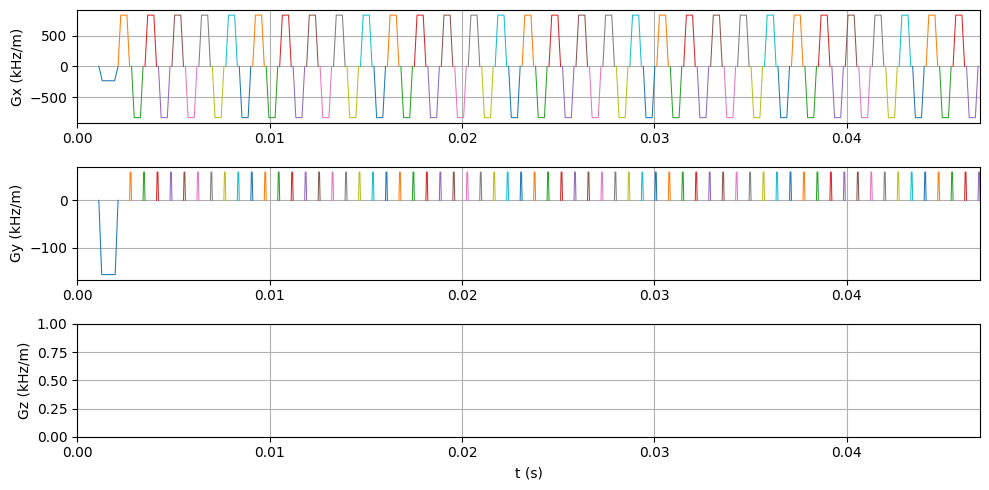

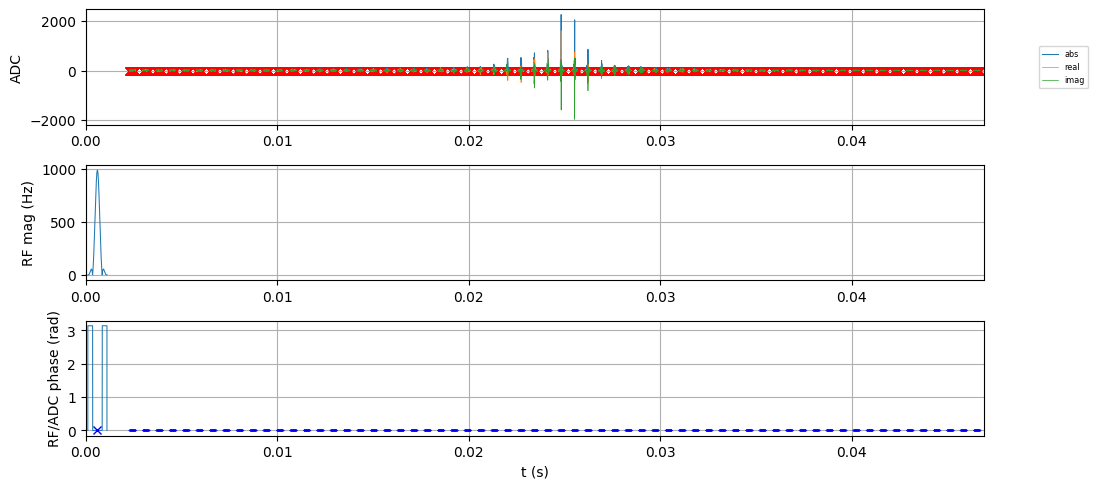

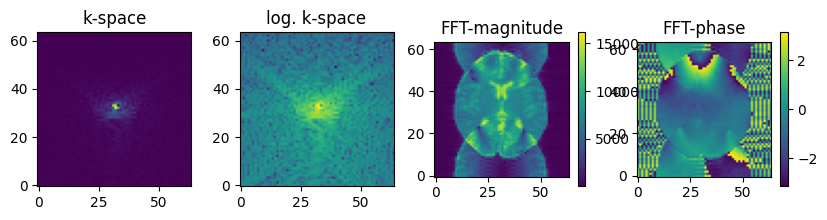

In [16]:
#@title quick 2D brain phantom sim and plot
fov = 240e-3 # @param {type:"number"} # Define FOV
slice_thickness = 8e-3
Nread = 64     # @param {type:"integer"} # frequency encoding steps/samples
Nphase = 64     # @param {type:"integer"} # phase encoding steps/samples
adc_duration_OG = 0.25e-3 # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3} # Moved to function parameters
eddy_currents=True # @param {type:"boolean"}
eddy_currents_induced_delay= 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8} # Moved to function parameters

seq = seq_gre_epi(fov=fov, slice_thickness=slice_thickness, Nread=Nread, Nphase=Nphase,eddy_currents=eddy_currents,eddy_currents_induced_delay=eddy_currents_induced_delay)

signal,_ = mr0.util.simulate(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [ ]:
# @title Export sequence as .seq file

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq_write_signature = seq.write(experiment_id + '.seq')

Timing check passed successfully


# Phantom changes

If you alter phantom parameters between

```
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
```
and
```
obj_p = obj_p.build()
```

you can alter the object manually to study phase images or distortions.

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


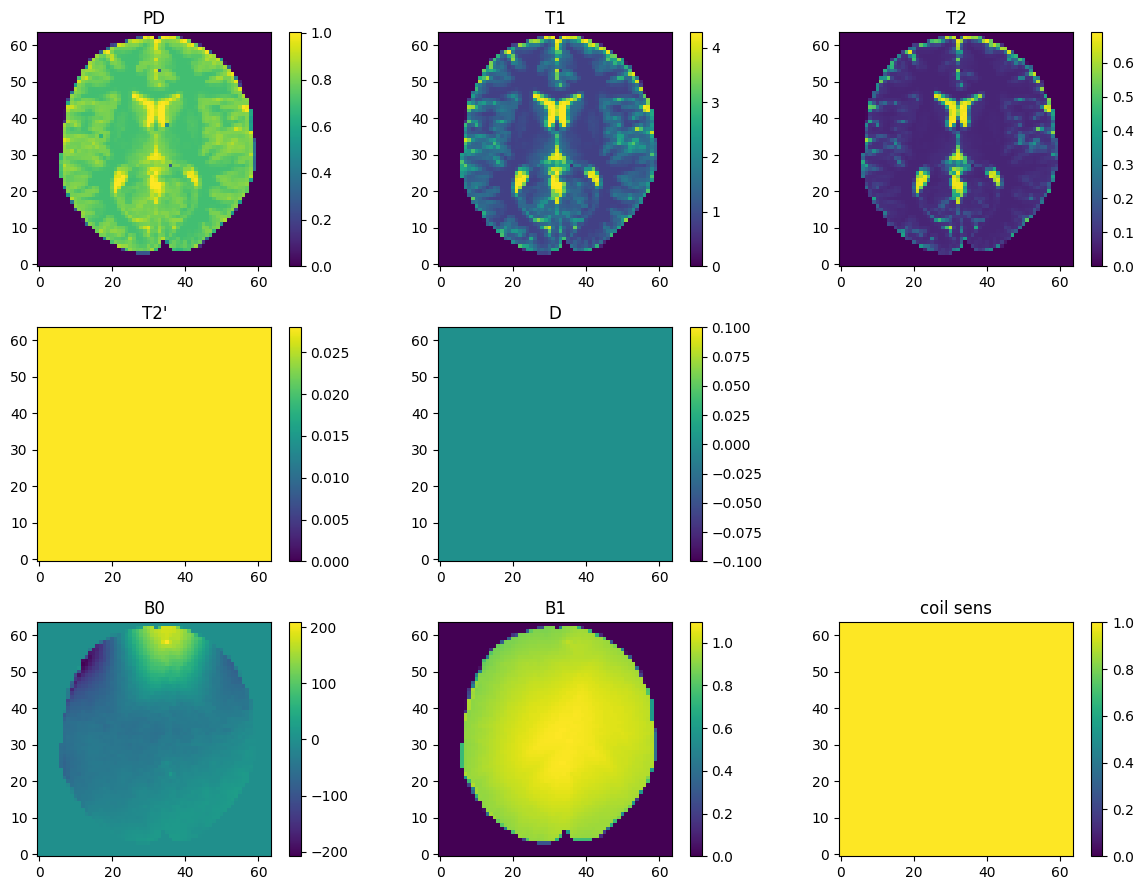

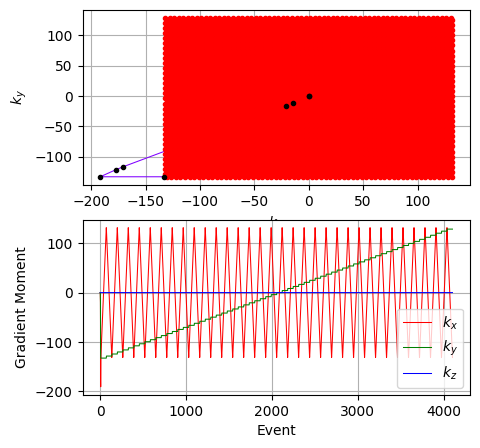

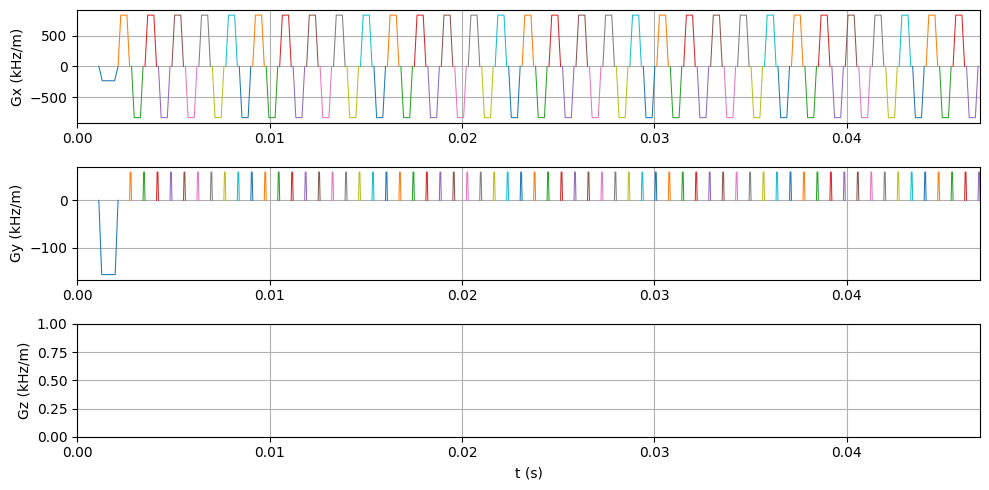

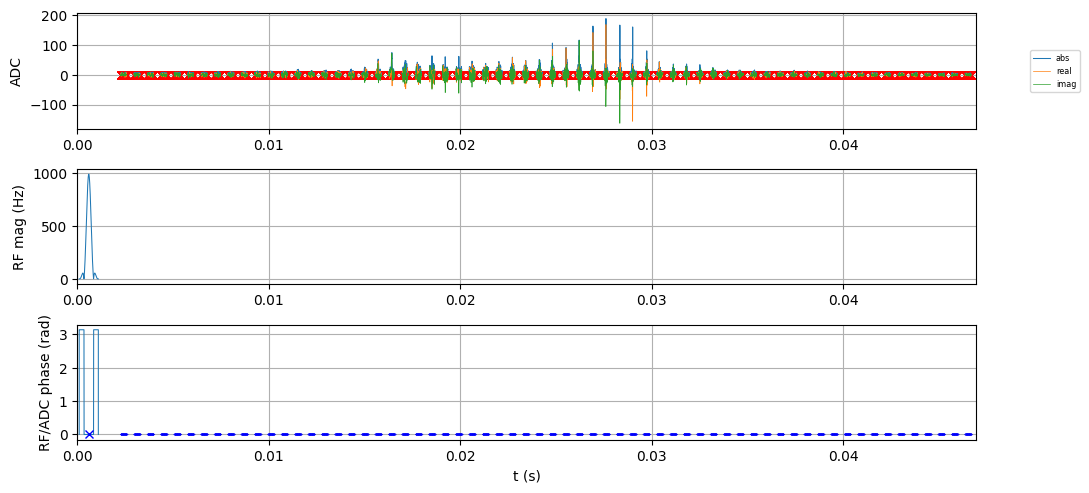

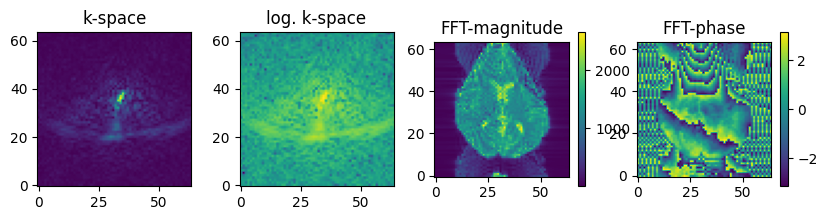

In [ ]:
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.D *= 0
T2dash=0.028001# @param {type: "slider", min: 1e-6, max: 100e-3, step:1e-3}
obj_p.T2dash[:] =T2dash
B0factor=5# @param {type: "slider", min: -20, max: 20, step:1}
obj_p.B0 *= B0factor    # alter the B0 inhomogeneity

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()